In [1]:
%load_ext autoreload
%autoreload 2

from dynamics import *

In [2]:
class DotProduct(nn.Module):
    def __init__(self):
        super().__init__()
    
    def forward(self, x):
        return torch.pow(x, 2).sum(dim=1)

# siamese network
class EBM(nn.Module):
    def __init__(self, input_shape):
        super().__init__()
        
        self.phi = nn.Sequential(
            nn.Linear(input_shape, 4*input_shape),
            nn.ReLU(),
            nn.Linear(4*input_shape, 8*input_shape),
            nn.ReLU(),
            nn.Linear(8*input_shape, 16*input_shape),
            nn.ReLU(),
            nn.Linear(16*input_shape, 16*input_shape),
            DotProduct()
        )

    def forward(self, x):
        return self.phi(x)

100%|██████████| 100/100 [01:59<00:00,  1.20s/it]


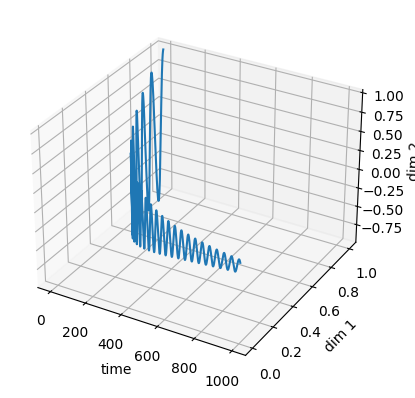

In [90]:
def positive_term_loss(batch):
    margin = 2

    x_t = batch[:-1, :]
    x_tp1 = batch[1:, :]

    E_x_t = model(x_t)
    E_x_tp1 = model(x_tp1)

    loss = torch.mean(torch.maximum(torch.zeros(x_t.shape[0]).cuda(), margin + (E_x_tp1 - E_x_t))**2)
    # loss = torch.mean(torch.exp(E_x_tp1 - E_x_t))

    return loss


def negative_term_loss(batch, num_negative_samples):
    margin = 2
    beta = 2

    losses = []

    for i in range(1, batch.shape[0]-1):
        num_samples = i - max(0, i - num_negative_samples)

        E_x_t = model(batch[i, :].unsqueeze(0)).repeat(num_samples)
        E_x_tp1 = model(batch[i - num_samples : i, :])
        
        loss = torch.sum(torch.maximum(torch.zeros(num_samples).cuda(), margin - (E_x_tp1 - E_x_t))**2)
        # loss = 1/beta * torch.log(torch.sum(torch.exp(-beta * (E_x_tp1 - E_x_t))))
        # loss = torch.sum(torch.exp(-(E_x_tp1 - E_x_t)))

        losses.append(loss)


    # for i in range(batch.shape[0]-1):
    #     E_x_t = model(batch[i, :].unsqueeze(0)).repeat(num_negative_samples)
    #     E_x_tp1 = model(generate_negative_samples(batch[i, :], angle=30, num_samples=num_negative_samples))
        
    #     # loss = torch.sum(torch.maximum(torch.zeros(num_samples).cuda(), margin - (E_x_tp1 - E_x_t))**2)
    #     # loss = 1/beta * torch.log(torch.sum(torch.exp(-beta * (E_x_tp1 - E_x_t))))
    #     loss = torch.sum(torch.exp(-(E_x_tp1 - E_x_t)))

    #     losses.append(loss)


    return sum(losses)/len(losses)


def epoch(iterations, bs, num_negative_samples):
    losses = []

    for i in range(iterations):
        batch = generate_batch(x, bs=bs)

        optimizer.zero_grad()

        loss = positive_term_loss(batch) + negative_term_loss(batch, num_negative_samples=num_negative_samples)

        loss.backward()

        optimizer.step()

        losses.append(loss.detach().cpu().item())

    return np.mean(losses)


x = dampened_oscillator(m=1.0, c=np.array([100.0, 0.1]), k=np.array([10.0, 10.0]))

plot_3d(x.cpu().numpy())


model = EBM(2).cuda()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

losses = []

for e in tqdm(range(100)):
    losses.append(epoch(iterations=10, bs=100, num_negative_samples=20))

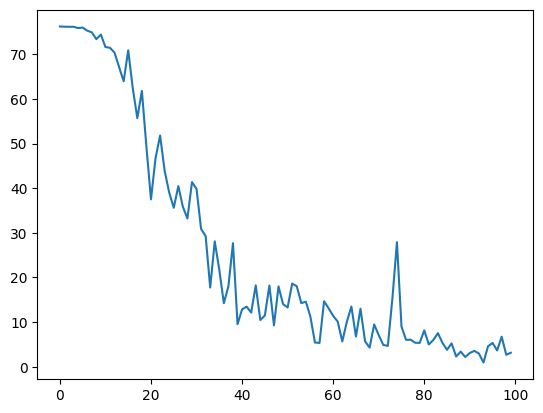

In [91]:
plt.plot(losses)

In [119]:
def energy_along_trajectory(model, trajectory):
    with torch.no_grad():
        E_x_t = []

        for x_t in trajectory:
            E_x_t.append(model(x_t.unsqueeze(0)).squeeze().detach().cpu().item())

    plt.plot(E_x_t)

In [118]:
def plot_energy_landscape(model):
    X = torch.linspace(-100, 100, steps=1000)
    Y = torch.linspace(-100, 100, steps=1000)

    space = torch.cartesian_prod(X, Y).cuda()

    energy_manifold = model(space).reshape(1000, 1000).detach().cpu().numpy()

    XX, YY = np.meshgrid(X.numpy(), Y.numpy())

    color_values = (energy_manifold - energy_manifold.min()) / (energy_manifold.max() - energy_manifold.min())

    cmap = plt.cm.viridis

    plt.figure(figsize=(10, 10))
    plt.pcolormesh(XX, YY, color_values, cmap=cmap)
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.colorbar()
    plt.show()

    

In [ ]:
fig = plt.figure()
ax = plt.axes(projection='3d')

ax.plot3D(XX, YY, )

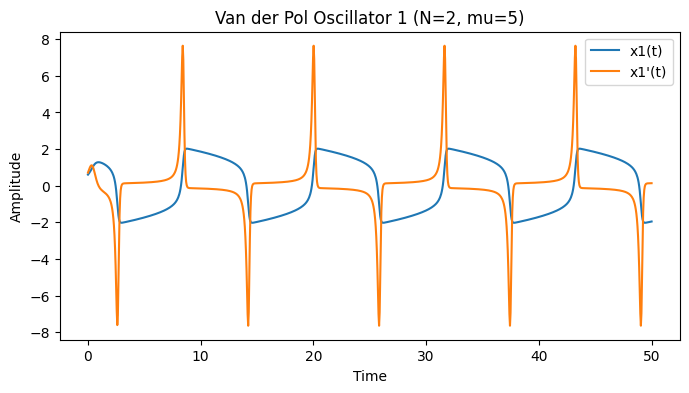

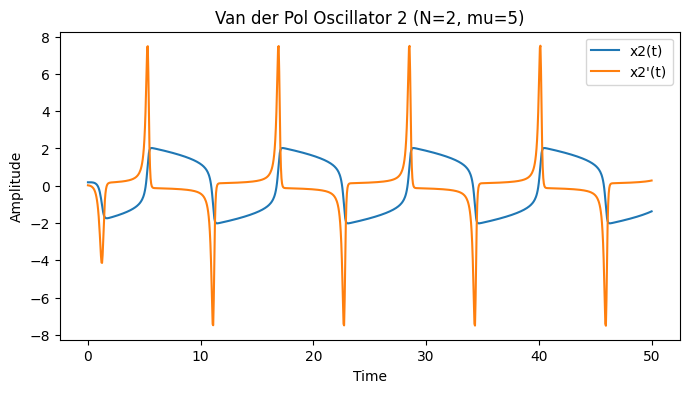

In [121]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

def van_der_pol_oscillator(N, mu):
    def vdp_equations(y, t, mu):
        dydt = np.zeros(N * 2)
        for i in range(0, N * 2, 2):
            dydt[i] = y[i + 1]
            dydt[i + 1] = mu * (1 - y[i]**2) * y[i + 1] - y[i]
        return dydt

    return vdp_equations

# Set parameters
N = 2
mu = 5

# Initial conditions
y0 = np.random.rand(N * 2)

# Time span for the simulation
t = np.linspace(0, 50, 1000)

# Solve the Van der Pol oscillator differential equations
vdp = van_der_pol_oscillator(N, mu)
solution = odeint(vdp, y0, t, args=(mu,))

# Plot the solution
for i in range(N):
    plt.figure(figsize=(8, 4))
    plt.plot(t, solution[:, i * 2], label=f"x{i+1}(t)")
    plt.plot(t, solution[:, i * 2 + 1], label=f"x{i+1}'(t)")
    plt.xlabel("Time")
    plt.ylabel("Amplitude")
    plt.legend()
    plt.title(f"Van der Pol Oscillator {i+1} (N={N}, mu={mu})")
    plt.show()


In [122]:
solution

array([[ 0.60485819,  0.71413683,  0.18091424,  0.02006222],
       [ 0.64270352,  0.79850969,  0.18180384,  0.01528588],
       [ 0.68479188,  0.88300507,  0.18242184,  0.00915738],
       ...,
       [-1.96553708,  0.13611498, -1.40459602,  0.26461203],
       [-1.95870365,  0.13694576, -1.39120196,  0.27067941],
       [-1.95182893,  0.137768  , -1.37749417,  0.2771559 ]])